In [105]:
%pylab notebook
import numpy as np
import cv2
import copy

from matplotlib import pyplot as plt
# numpy.set_printoptions(threshold=numpy.nan)

Populating the interactive namespace from numpy and matplotlib


/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['copy', 'indices', 'hsv', 'diagonal']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [106]:
def edgeSobel(img):
    #function to smooth the input image and detect edges
    y = img.shape[0]
    x = img.shape[1]


    #input filter size
    fs = 3
    v = int((fs-1)/2)

    #initialize filter matrix with 1's
    filter = np.ones([fs,fs], dtype=float)

    #copy the input image to the new image so that borders are pereserved
    filteredImage = copy.deepcopy(img)
    filteredImage.astype(float)

    #loop to filter the input image and save it as a new image
    for k in range(1, y-v):
        for l in range(1, x-v):
            sum = 0.0
            m = k-v
            n = l-v
            for i in range(0, fs):
                for j in range(0, fs):
                    sum+= filter[i][j]  * float(img[m+i][n+j])
            filteredImage[k][l] = (sum / (fs*fs))

    #Intialise the first derivative matrix along x-direction
    dx= np.zeros([y,x], dtype=float)
    dx.astype(float)

    #loop to convolve the image with the [-1/2,0,1/2] mask
    for i in range(0, y-1):
        for j in range(1, x-2):
            dx[i][j] = float(-((0.5)* filteredImage[i][j-1]) + ((0.5) * filteredImage[i][j+1]))

    #save and show the image
    figure()
    plt.imshow(dx, cmap='gray')
    plt.show()

    #Intialise the first derivative matrix along y-direction
    dy= np.zeros([y,x], dtype=float)
    for i in range(0, x-1):
        for j in range(1, y-2):
            dy[j][i] = float(-((0.5)* filteredImage[j-1][i]) + ((0.5) * filteredImage[j+1][i]))
    
    figure()
    plt.imshow(dy, cmap='gray')
    plt.show()


    #Intialise the edge map matrix
    dxdy = np.zeros([y,x], dtype=float)

    #loop to calculate the vector norm i.e., edge map
    for i in range(0, y-1):
        for j in range(0, x-1):
            dxdy[i][j] = math.sqrt ((dx[i][j] * dx[i][j]) + (dy[i][j] * dy[i][j]))

    figure()
    plt.imshow(dxdy, cmap='gray')
    plt.show()
    
    
    edgeImage= np.zeros([y,x], dtype=float)
    edgePoints=[]
    for i in range(0, y):
        for j in range(0, x):
            if dxdy[i][j] > 21:
                edgeImage[i][j]=1
                edgePoints.append((i,j))
                
    figure()
    plt.imshow(edgeImage, cmap='gray')
    plt.show()
    
    return edgePoints
   

In [107]:
def accumulatorArray(img, edgePoints):
    #function to generate the accumulator array and display it
    
    x, y = img.shape
    thetas = np.arange(-90, 90, 1)
    
    diagonal = int(round(math.sqrt(x * x + y * y)))
    
    
    accumulator = np.zeros((2 * diagonal, len(thetas)), dtype=int)
    
    for x, y in edgePoints:
        for angle in thetas:
            theta = np.deg2rad(angle)
            rho = int((x*np.cos(theta)) + (y* np.sin(theta)))
            if -diagonal <= rho <= diagonal:
                accumulator[diagonal+rho, 90+angle] += 1
            
    figure()
    plt.title("Hough Accumulator")
    plt.imshow(accumulator, cmap='gray', aspect='auto')
    plt.show()
            
    return accumulator, diagonal
        
        

In [108]:
def NMS(accumulator):
    #function to apply Non maxima suppression to the accumulator array
    shape = accumulator.shape
    nmsAccumulator = np.zeros(shape, dtype='float')
    for x in range(1, shape[0]-2):
        for y in range(1, shape[1]-2):
            flag =0
            for i in range(x-1, x+2):
                for j in range(y-1, y+2):
                    if accumulator[x][y] < accumulator[i][j]:
                        flag = 1
                        break
                if flag == 1:
                    break
            if flag == 0:
                nmsAccumulator[x][y] = accumulator[x][y]
    return nmsAccumulator
    
    

In [109]:
def nmsAccThreshold(acc):
    #function to apply threshold to accumulator array to get a subset of highest peaks
    nmsacc = copy.deepcopy(acc)
    thresholdedNMSAcc = np.zeros(nmsacc.shape)
    shape = thresholdedNMSAcc.shape
    for x in range(0, shape[0]):
        for y in range(0, shape[1]):
            if nmsacc[x][y] > 150:
                thresholdedNMSAcc[x][y] = 1
                
    return thresholdedNMSAcc
            
    
    

In [110]:
def points(tacc):
    #function to get the indices of the peaks
    index=[]
    for x in range(0, tacc.shape[0]):
        for y in range(0, tacc.shape[1]):
            if tacc[x][y]==1:
                index.append((x,y))
                
    return index
    
    

<IPython.core.display.Javascript object>


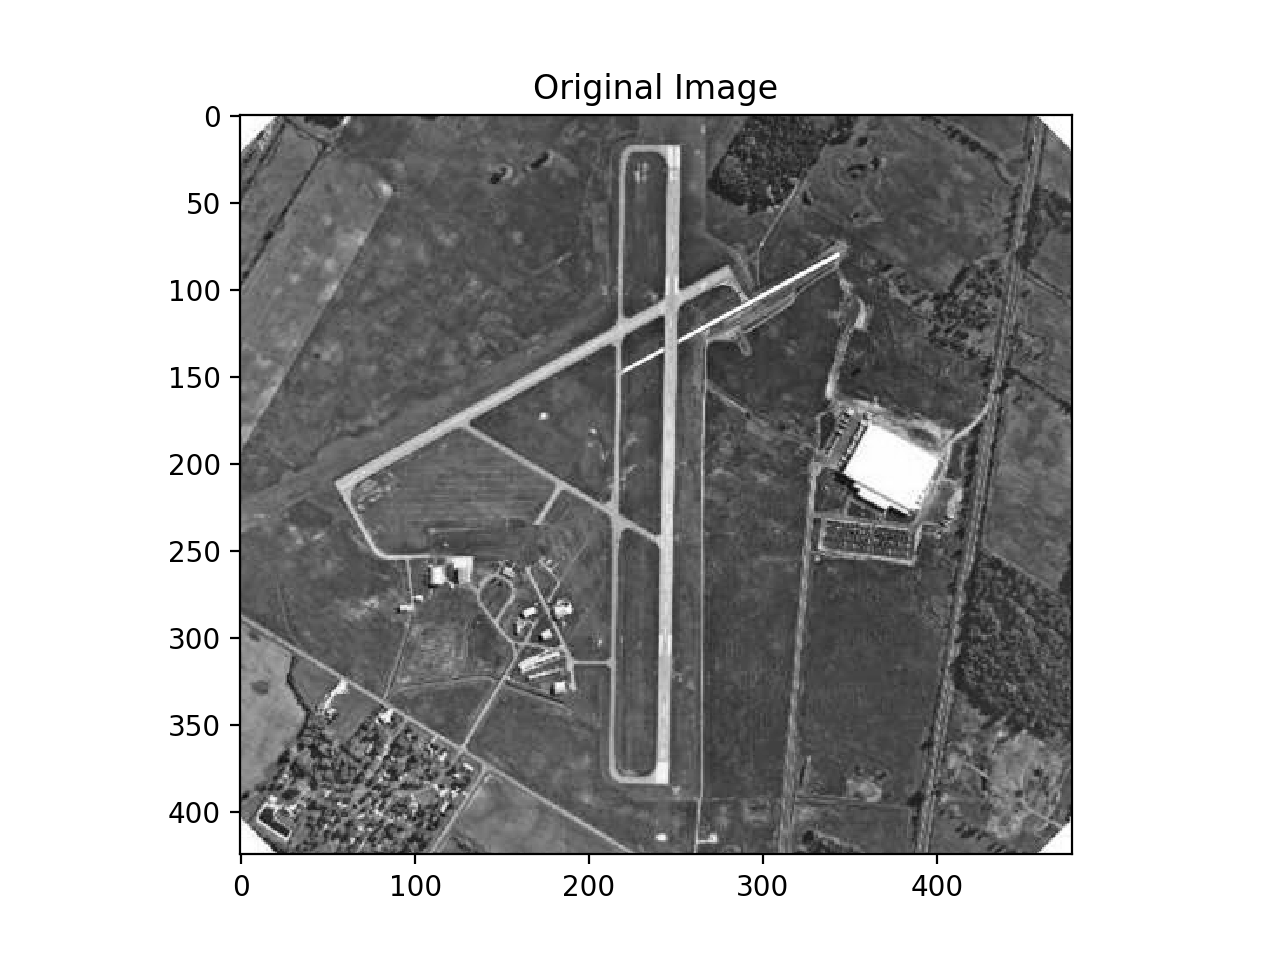

<IPython.core.display.Javascript object>


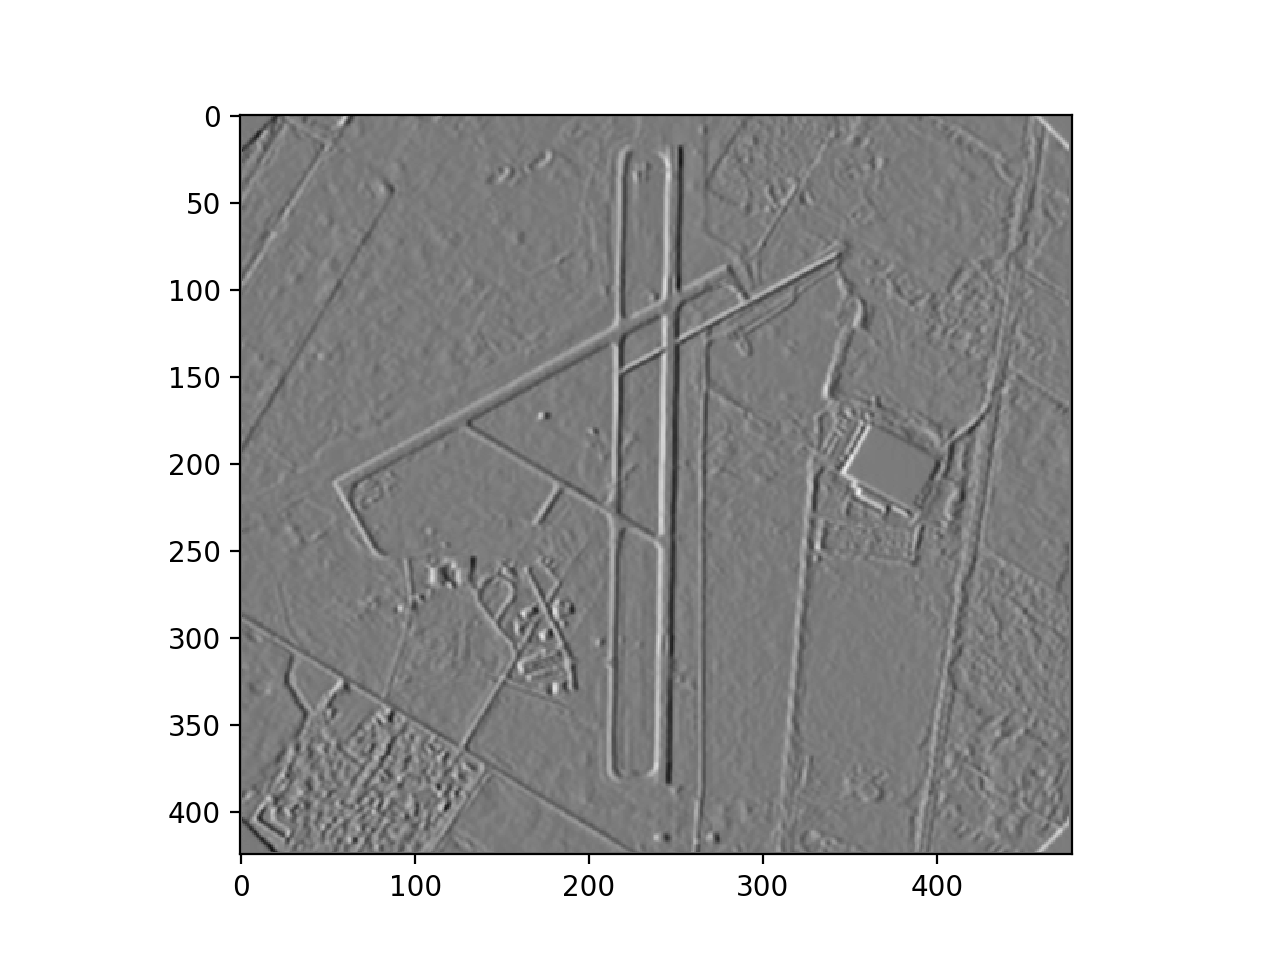

<IPython.core.display.Javascript object>


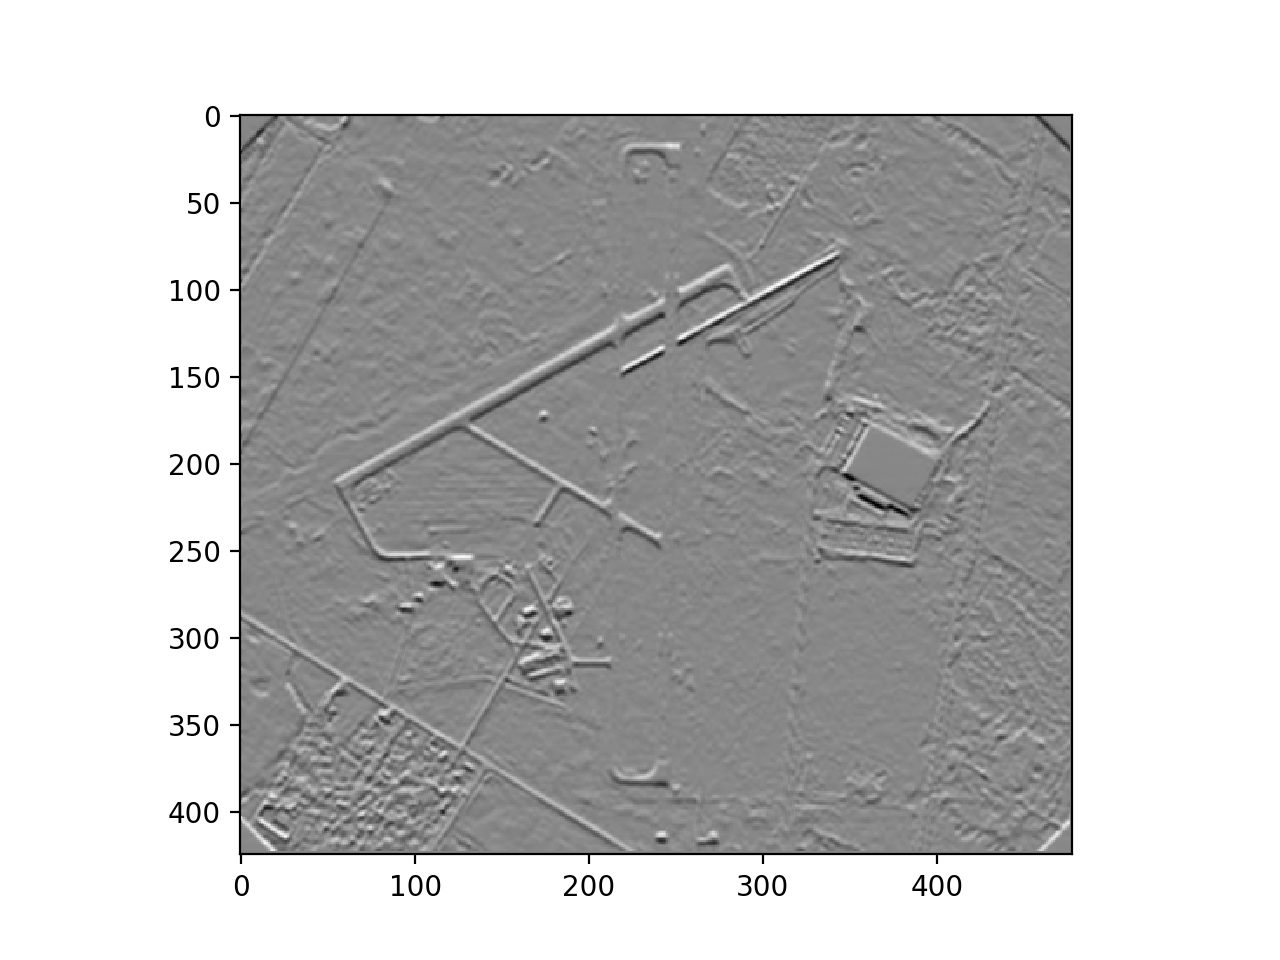

<IPython.core.display.Javascript object>


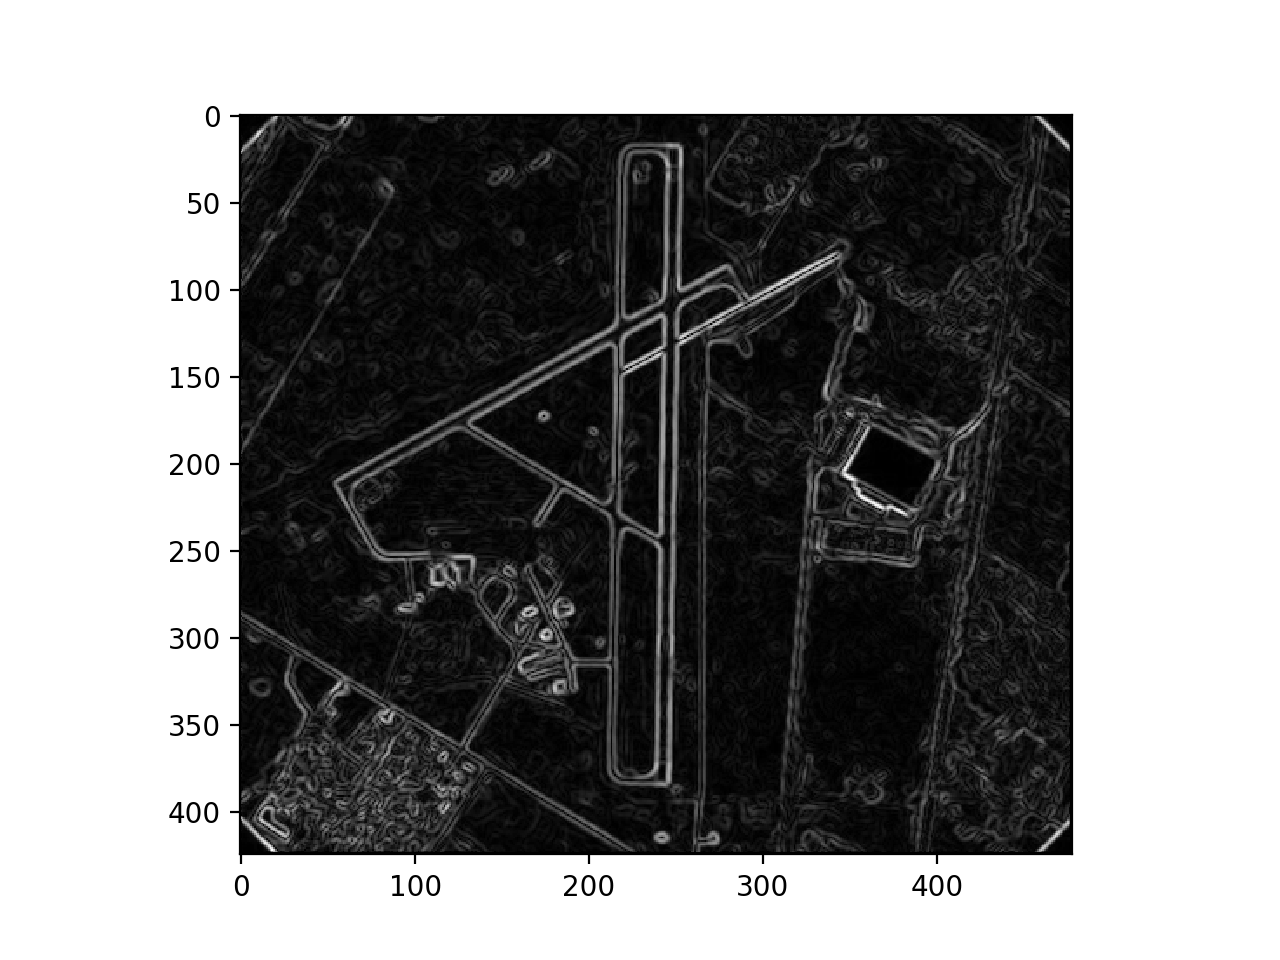

<IPython.core.display.Javascript object>


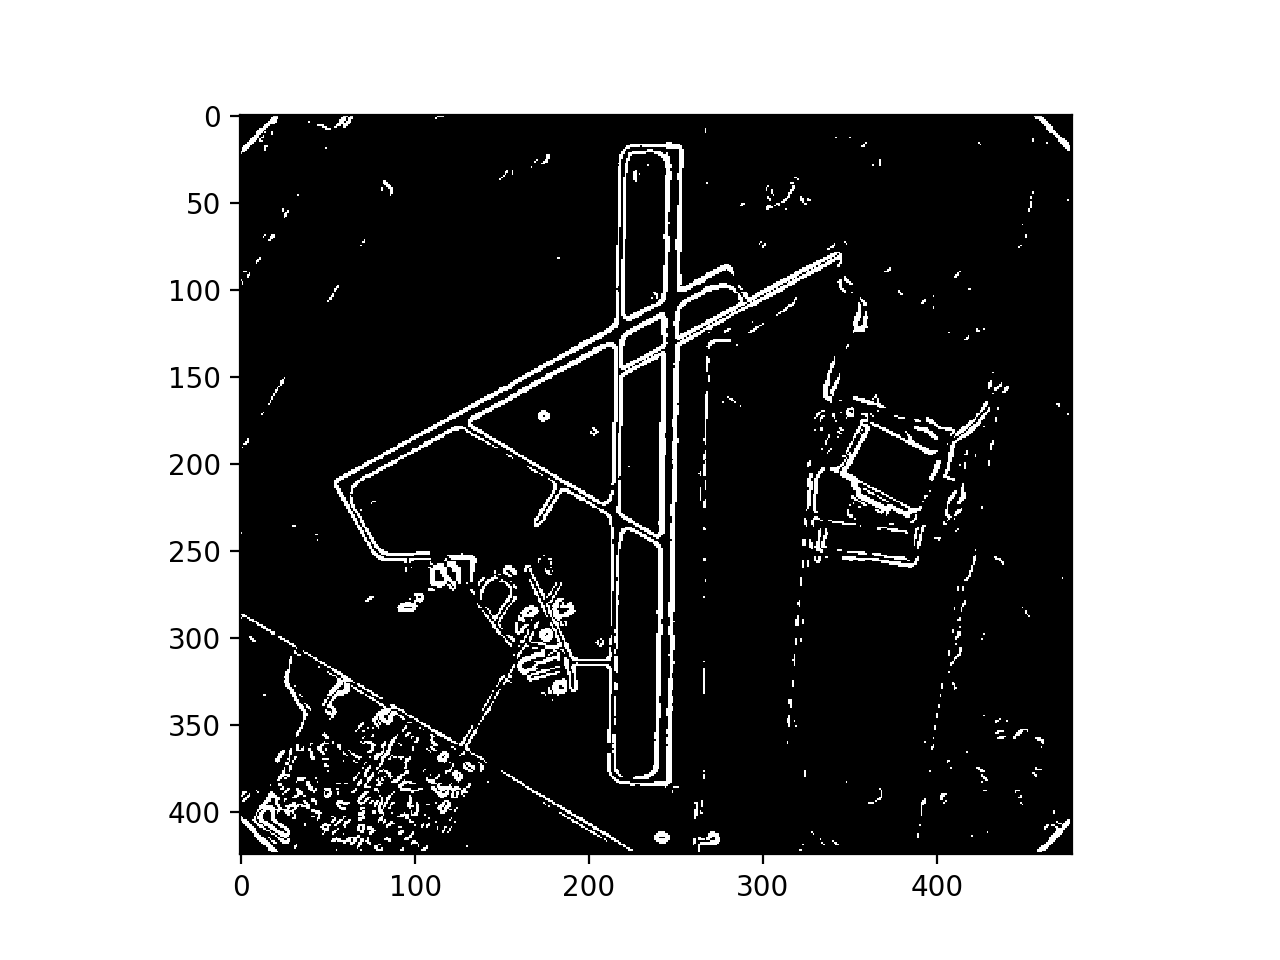

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


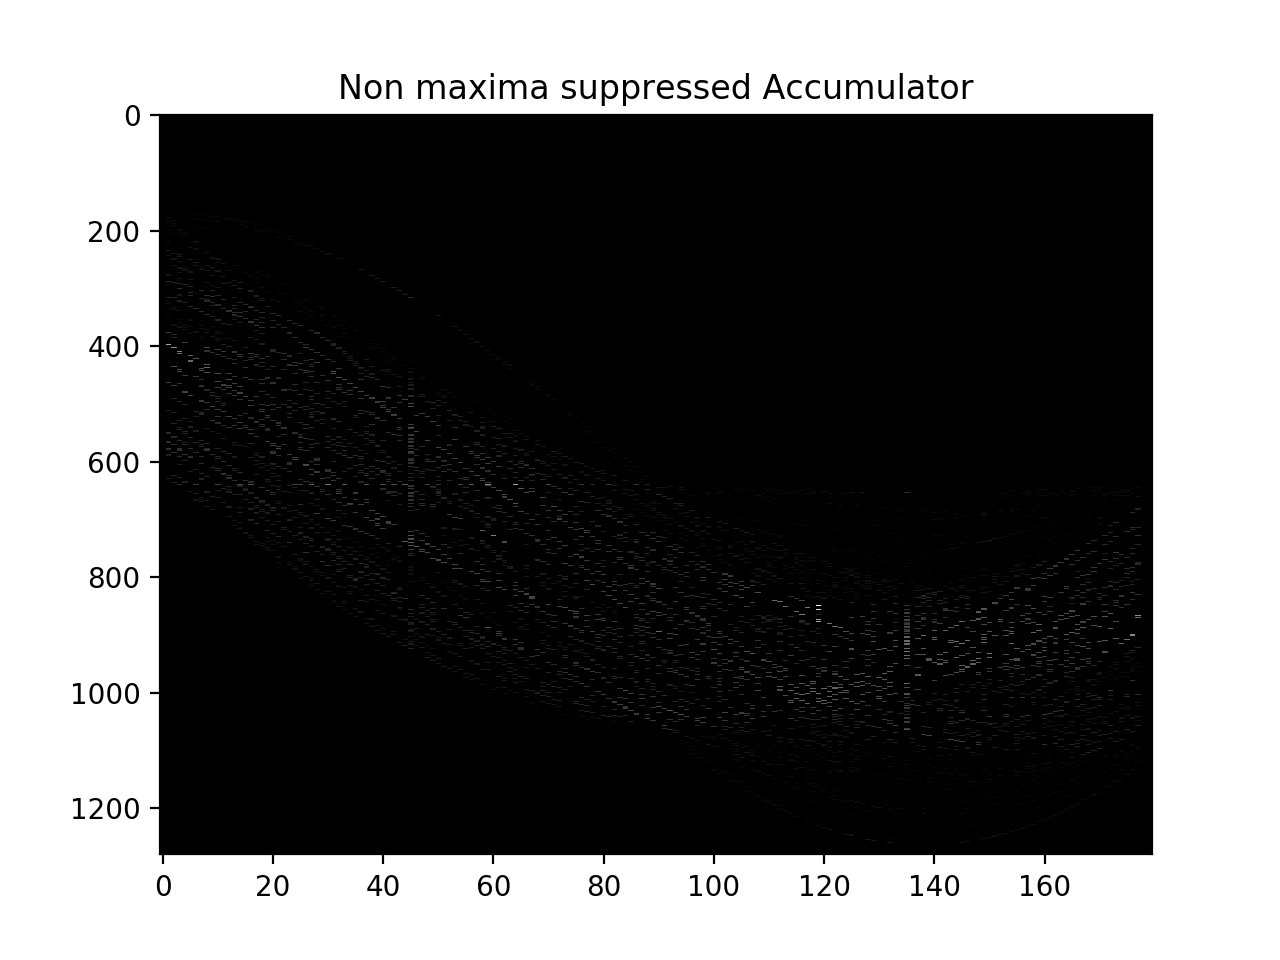

<IPython.core.display.Javascript object>


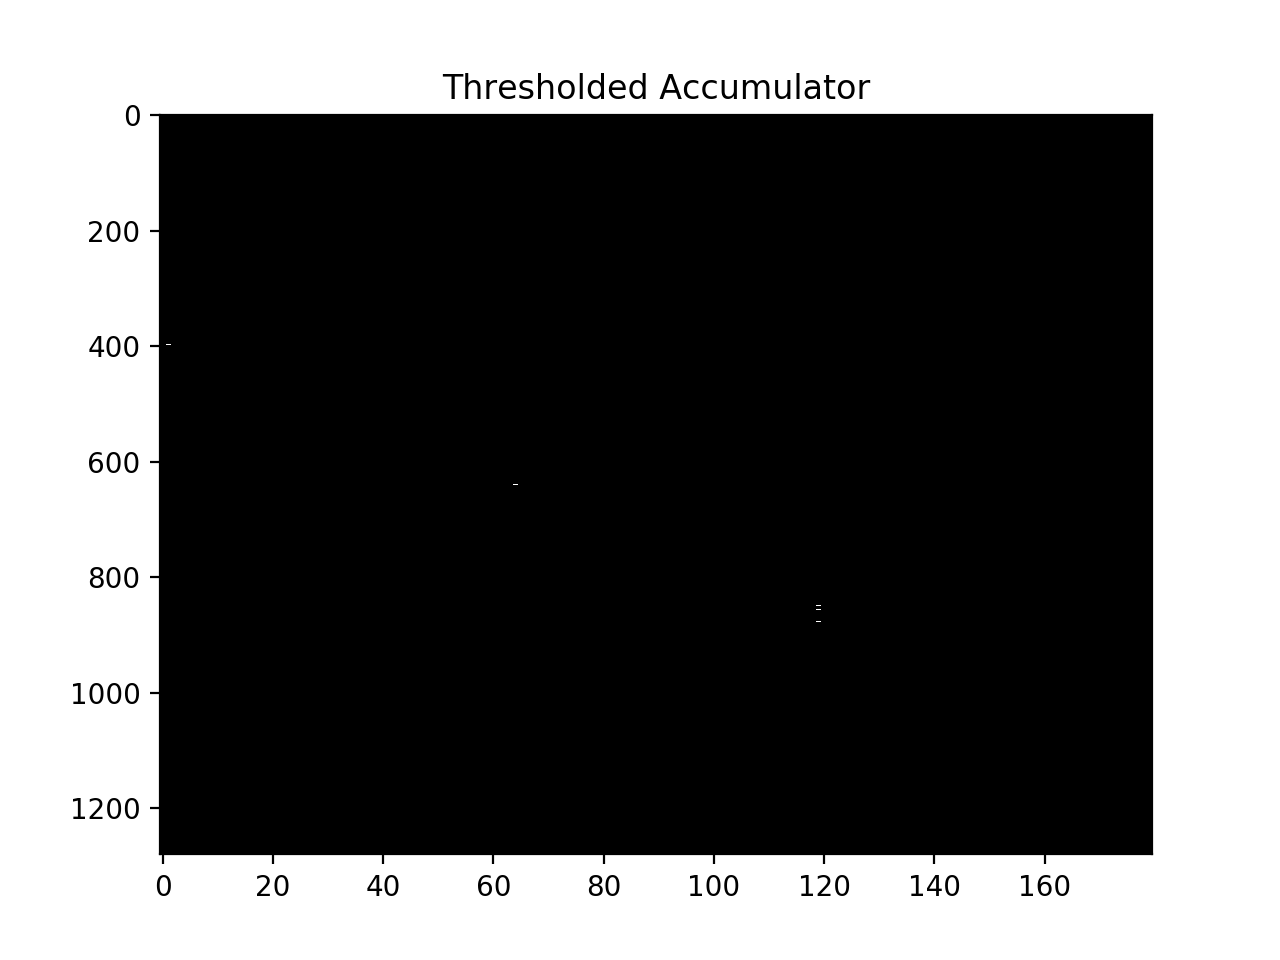

<IPython.core.display.Javascript object>


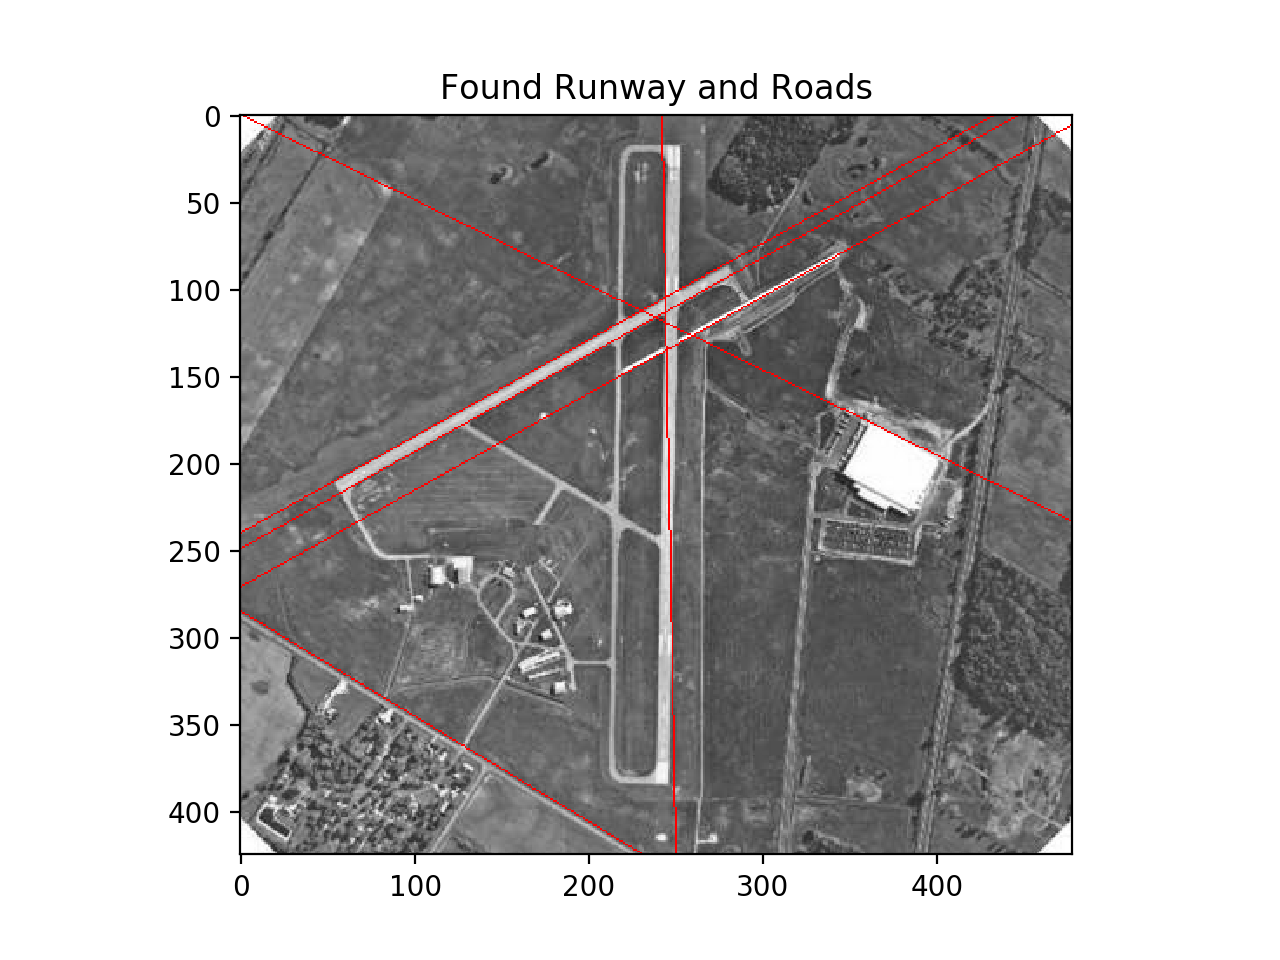

In [112]:
if __name__ == "__main__":
    # Create a grayscale image
    img = cv2.imread('mnn4-runway-Ohio.jpg',0)
   

    figure()
    plt.title("Original Image")
    plt.imshow(img,  cmap='gray')
    
    #calculate the edges of the image
    edgePoints = edgeSobel(img)
    
    #generate the accumulator array
    accumulator, diagonal = accumulatorArray(img, edgePoints)
    nmsAcc = NMS(accumulator)
    
    figure()
    plt.title("Non maxima suppressed Accumulator")
    plt.imshow(nmsAcc, cmap='gray', aspect='auto')
    
    
    thresholdNMSAcc = nmsAccThreshold(nmsAcc)
    figure()
    plt.title("Thresholded Accumulator")
    plt.imshow(thresholdNMSAcc, cmap='gray', aspect='auto')
    
    #get the indices of the peaks
    indices = points(thresholdNMSAcc)
    
    #convert the grayscale image to BGR
    hsv = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    #draw back the detected lines on the original image
    for loc in range(0, len(indices)):
        r, t = indices[loc]
    
        rho = r - diagonal
        theta = np.deg2rad(t - 90)
        if theta!= 0:
            x1 = 0
            y1 = int(rho/ np.sin(theta))

            x2 = img.shape[1]
            y2 = int((rho - (x2* np.cos(theta))) / np.sin(theta))



            cv2.line(hsv,(y1,x1),(y2, x2),(255,0,0),1)
    
    
    figure()
    plt.title("Found Runway and Roads")
    plt.imshow(hsv)
    

    